# Inference Test 😎

In [14]:
from dataclasses import dataclass
import jax.numpy as jnp

@dataclass
class Problem:
    n : int
    rigid_cov : jnp.array
    transition_cov : jnp.array
    
    """
    amplify_fun(1, 0.02, 0.1),
    amplify_fun(1, 0.25, 0.1),
    amplify_fun(30, 0.001, 0.0001),
    amplify_fun(5, 0.02, 0.005),
    amplify_fun(3, 0.05, 0.01)"""

# "no_rigid_phases" <- normal run
    
problems = {
    "best_run" : Problem(1, jnp.array([0.02]), jnp.array([0.1])),
    "long_rigid_phase" : Problem(1, jnp.array([0.25]), jnp.array([0.1])),
    "many_tiny_stops" : Problem(30, jnp.array([0.001] * 30), jnp.array([0.0001] * 30)),
    "some_short_stops_1" : Problem(5, jnp.array([0.02] * 5), jnp.array([0.005] * 5)),
    "some_rigid_phases" : Problem(3, jnp.array([0.05] * 3), jnp.array([0.01] * 3)),
    "best_run_2" : Problem(1, jnp.array([0.02]), jnp.array([0.1])),
    "long_rigid_phase_2" : Problem(1, jnp.array([0.25]), jnp.array([0.1])),
    "some_short_stops" : Problem(5, jnp.array([0.02] * 5), jnp.array([0.005] * 5)),
    "some_rigid_phases_2" : Problem(3, jnp.array([0.05] * 3), jnp.array([0.01] * 3))
}

### Generate Data

Define System

In [31]:
import x_xy

three_seg_rigid = r"""
<x_xy model="three_seg_rigid">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="seg2" joint="free">
            <geom type="box" mass="10" pos="0.1 0 0" dim="0.2 0.05 0.05" vispy_color="red"/>
            <body name="seg1" joint="rsry" pos="0 0 0">
                <geom type="box" mass="10" pos="-0.1 0 0" dim="-0.2 0.05 0.05" vispy_color="yellow"/>
                <body name="imu1" pos="-0.1 0.0 0.03" joint="frozen">
                    <geom type="box" mass="2" pos="0 0 0" dim="0.05 0.01 0.01" vispy_color="lightgreen"/>
                </body>
            </body>
            <body name="seg3" joint="rsrz" pos="0.2 0 0">
                <geom type="box" mass="10" pos="0.1 0 0" dim="0.2 0.05 0.05" vispy_color="blue"/>
                <body name="imu2" joint="frozen" pos="0.1 0.0 0.03">
                    <geom type="box" mass="2" pos="0 0 0" dim="0.05 0.01 0.01" vispy_color="lightgreen"/>
                </body>
            </body>
        </body>
    </worldbody>
    <defaults>
        <geom vispy_edge_color="black" vispy_color="1 0.8 0.7 1"/>
    </defaults>
</x_xy>
"""

dustin_exp_xml_seg1 = r"""
<x_xy model="dustin_exp">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="seg1" joint="free">
            <geom type="box" mass="10" pos="1 0 0" dim="1 0.25 0.2"/>
            <body name="seg2" joint="ry">
                <geom type="box" mass="10" pos="1 0 0" dim="1 0.25 0.2"/>
                <body name="seg3" joint="rz"></body>
                    <geom type="box" mass="10" pos="1 0 0" dim="1 0.25 0.2"/>
            </body>
        </body>
    </worldbody>
</x_xy>
"""

Define Logic

In [23]:
import jax
import jax.numpy as jnp
from jax import random
import x_xy

"""
Calculates an amplifying-function, which can be used to decrease the values of another array with the same length.
An array of shape (time / sampling rate) will be returned, containing values between 0 and 1.
The covariance values are relative to the length of the array that will be created.
"""


def motion_amplifier(
        time,
        sampling_rate,
        key_rigid_phases,
        n_rigid_phases=3,
        rigid_duration_cov=jnp.array([0.02] * 3),
        transition_cov=jnp.array([0.1] * 3)
) -> jnp.ndarray:
    assert rigid_duration_cov.shape == (n_rigid_phases,) == transition_cov.shape, "motion_amplifier: There must be a variance for each rigid phase!"
    n_frames = int(time / sampling_rate)
    key_rigid_means, key_rigid_variances, key_slope_down_variances, key_slope_up_variances = random.split(
        key_rigid_phases, 4)

    # Calculate center points of rigid phases
    means = jnp.sort(random.uniform(key_rigid_means, shape=(
        n_rigid_phases, 1), minval=0, maxval=n_frames).T)

    # Calculate durations, which is twice the rigid distance from the center points for each rigid phase.
    rigid_distances = jnp.abs(random.multivariate_normal(key_rigid_variances, mean=jnp.zeros_like(
        means), cov=jnp.diag((rigid_duration_cov * n_frames)**2)))

    # Calculate transition durations
    transition_slowdown_durations = jnp.abs(random.multivariate_normal(
        key_slope_down_variances, mean=jnp.zeros_like(means), cov=jnp.diag((transition_cov * n_frames)**2)))
    transition_speedup_durations = jnp.abs(random.multivariate_normal(
        key_slope_up_variances, mean=jnp.zeros_like(means), cov=jnp.diag((transition_cov * n_frames)**2)))

    # Phase start and end points
    rigid_starts = (means - rigid_distances).astype(int).flatten()
    rigid_ends = (means + rigid_distances).astype(int).flatten()
    starts_slowing = (means - rigid_distances -
                      transition_slowdown_durations).astype(int).flatten()
    ends_moving = (means + rigid_distances +
                   transition_speedup_durations).astype(int).flatten()

    # Create masks
    def create_mask(start, end):
        nonlocal n_frames
        return jnp.where(jnp.arange(n_frames) < start, 1, 0) + jnp.where(jnp.arange(n_frames) >= end, 1, 0)

    mask = jax.vmap(create_mask)
    rigid_mask = jnp.prod(mask(rigid_starts, rigid_ends), axis=0)
    slowdown_masks = mask(starts_slowing, rigid_starts).astype(float)
    speedup_masks = mask(rigid_ends, ends_moving).astype(float)

    def linsp(mask, start, end, begin_val, carry_fun):
        range = end - start
        def true_fun(carry, x): return (carry_fun(carry, range), 1 - carry)
        def false_fun(carry, x): return (carry, x)
        def f(carry, x): return jax.lax.cond(
            x == 0, true_fun, false_fun, *(carry, x))
        return jax.lax.scan(f, begin_val, mask)[1]

    linsp_desc = jax.vmap(lambda m, s1, s2: linsp(
        m, s1, s2, 0.0, lambda carry, range: carry + 1/range))
    slowdown_mask = jnp.prod(linsp_desc(
        slowdown_masks, starts_slowing, rigid_starts), axis=0)

    linsp_asc = jax.vmap(lambda m, s1, s2: linsp(
        m, s1, s2, 1.0, lambda carry, range: carry - 1/range))
    speedup_mask = jnp.prod(
        linsp_asc(speedup_masks, rigid_ends, ends_moving), axis=0)

    return jnp.min(jnp.stack([rigid_mask, slowdown_mask, speedup_mask]), axis=0)


def random_angles_with_rigid_phases_over_time(
    key_t,
    key_ang,
    T,
    Ts,
    key_rigid_phases,
    n_rigid_phases=3,
    rigid_duration_cov=jnp.array([0.02] * 3),
    transition_cov=jnp.array([0.1] * 3),
    ANG_0=0.0,
    dang_min=0.01,
    dang_max=0.05,
    t_min=0.1,
    t_max=0.5,
    randomized_interpolation=False,
    range_of_motion=False,
    range_of_motion_method="uniform"
):
    mask = motion_amplifier(T, Ts, key_rigid_phases,
                            n_rigid_phases, rigid_duration_cov, transition_cov)

    qs = x_xy.algorithms.random_angle_over_time(
        key_t=key_t,
        key_ang=key_ang,
        ANG_0=ANG_0,
        dang_min=dang_min,
        dang_max=dang_max,
        delta_ang_min=0.0,
        delta_ang_max=2 * jnp.pi,
        t_min=t_min,
        t_max=t_max,
        T=T,
        Ts=Ts,
        randomized_interpolation=randomized_interpolation,
        range_of_motion=range_of_motion,
        range_of_motion_method=range_of_motion_method
    )

    # derivate qs
    qs_diff = jnp.diff(qs, axis=0)

    # mulitply with motion amplifier
    qs_diff = qs_diff * mask[:-1]

    # integrate qs_diff
    qs_rigid_phases = jnp.concatenate((qs[0:1], jnp.cumsum(qs_diff, axis=0)))
    return qs_rigid_phases


In [32]:
import jax
from x_xy import maths
from x_xy import base

@dataclass
class ExtendedConfig(x_xy.algorithms.RCMG_Config):
    n_rigid_phases : int = 3
    cov_rigid_durations : jax.Array = jnp.array([0.02] * n_rigid_phases)
    cov_transitions : jax.Array = jnp.array([0.1] * n_rigid_phases)
    
    def __post_init__(self):
        assert self.cov_rigid_durations.shape == self.cov_transitions.shape
        
def define_joints():

    
    def _draw_sometimes_rigid(
            config: ExtendedConfig, key_t: jax.random.PRNGKey, key_value: jax.random.PRNGKey
    ) -> jax.Array:
        key_t, key_rigid_phases = jax.random.split(key_t)
        return random_angles_with_rigid_phases_over_time(
            key_t=key_t,
            key_ang=key_value,
            T=config.T,
            Ts=config.Ts,
            key_rigid_phases=key_rigid_phases,
            n_rigid_phases=config.n_rigid_phases,
            rigid_duration_cov=config.cov_rigid_durations,
            transition_cov=config.cov_transitions,
            ANG_0=0,
            dang_min=config.dang_min,
            dang_max=config.dang_max,
            t_min=config.t_min,
            t_max=config.t_max,
            randomized_interpolation=config.randomized_interpolation_angle, # ???????????????????????
            range_of_motion=config.range_of_motion_hinge,
            range_of_motion_method=config.range_of_motion_hinge_method
        )

    def _rxyz_transform(q, _, axis):
        q = jnp.squeeze(q)
        rot = maths.quat_rot_axis(axis, q)
        return base.Transform.create(rot=rot)

    rsrx_joint = x_xy.algorithms.JointModel(
        lambda q, _: _rxyz_transform(q, _, jnp.array([1.0, 0, 0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
    )
    rsry_joint = x_xy.algorithms.JointModel(
        lambda q, _: _rxyz_transform(q, _, jnp.array([0, 1.0, 0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
    )
    rsrz_joint = x_xy.algorithms.JointModel(
        lambda q, _: _rxyz_transform(q, _, jnp.array([0, 0, 1.0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
    )
    x_xy.algorithms.register_new_joint_type("rsrx", rsrx_joint, 1)
    x_xy.algorithms.register_new_joint_type("rsry", rsry_joint, 1)
    x_xy.algorithms.register_new_joint_type("rsrz", rsrz_joint, 1)
    
try:
    define_joints()
except AssertionError:
    pass

sys = x_xy.io.load_sys_from_str(three_seg_rigid)

Define Problems

Generate random data

In [16]:
from jax import random
from x_xy.algorithms import random_angle_over_time

KEYNUM = 6

problem = problems["some_rigid_phases"]

key_t = random.PRNGKey(KEYNUM)
key_ang = random.PRNGKey(KEYNUM)
key_rigid_phases = random.PRNGKey(KEYNUM)
T = 60
Ts = 0.1

std_config = x_xy.algorithms.RCMG_Config()
extended_config = ExtendedConfig(n_rigid_phases=problem.n, cov_rigid_durations=problem.rigid_cov, cov_transitions=problem.transition_cov)

mask = motion_amplifier(T, Ts, key_t, problem.n, problem.rigid_cov, problem.transition_cov)
angles = random_angles_with_rigid_phases_over_time(key_t=key_t , key_ang=key_ang, key_rigid_phases=key_rigid_phases, T=T, Ts=Ts, n_rigid_phases=problem.n, rigid_duration_cov=problem.rigid_cov, transition_cov=problem.transition_cov)
# angles_normal = random_angle_over_time(key_t=key_t, key_ang=key_ang, T=T, Ts=Ts, ANG_0=0, dang_min=std_config.dang_min, dang_max=std_config.dang_max, t_min=std_config.t_min, t_max=std_config.t_max)

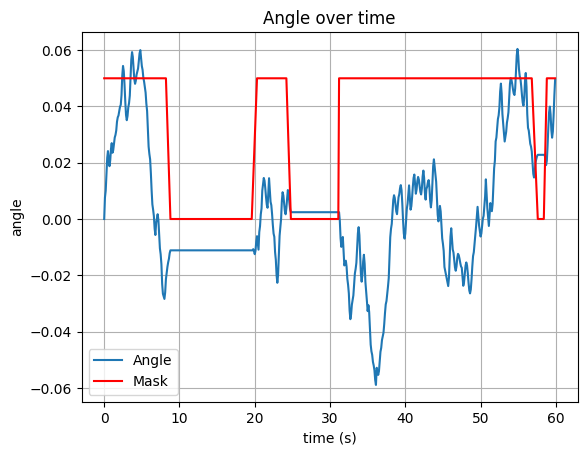

In [17]:
# plot angle data
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(np.arange(0, T, Ts), angles)
ax.plot(np.arange(0, T, Ts), mask * 0.05, color="red")
ax.set(xlabel='time (s)', ylabel='angle', title='Angle over time')
ax.legend(["Angle", "Mask"])
ax.grid()
plt.show()


### Generate X and y

In [18]:
from x_xy import algorithms, utils

def finalize_fn_imu_data(key, q, x, sys):
    imu_seg_attachment = {"imu1": "seg1", "imu2": "seg3"}

    X = {}
    for imu, seg in imu_seg_attachment.items():
        key, consume = jax.random.split(key)
        X[seg] = x_xy.algorithms.imu(
            x.take(sys.name_to_idx(imu), 1), sys.gravity, sys.dt, consume, True
        )
    return X

def finalize_fn_rel_pose_data(key, _, x, sys):
    # Defines what the network should predict
    dustin_sys = x_xy.io.load_sys_from_str(dustin_exp_xml_seg1)
    y = x_xy.algorithms.rel_pose(sys_scan=dustin_sys, xs=x, sys_xs=sys)
    return y


def finalize_fn(key, q, x, sys):
    X = finalize_fn_imu_data(key, q, x, sys)
    y = finalize_fn_rel_pose_data(key, q, x, sys)
    return X, y, x

config = extended_config
generator = algorithms.build_generator(sys, config, finalize_fn=finalize_fn)
# we can even batch together multiple generators
# generator = algorithms.batch_generator([generator, generator], [32, 16])
seed = jax.random.PRNGKey(1,)
X, y, xs = generator(seed)

In [27]:
print(X.keys())
print(X["seg1"].keys())
print(y.keys())

dict_keys(['seg1', 'seg3'])
dict_keys(['acc', 'gyr'])
dict_keys(['seg2', 'seg3'])


Open Pickle file and store data

In [7]:
def load_pickle_params(problem_key):
    from neural_networks import io_params
    pickle_file = f"/data/uk16ural/prism_params/{problem_key}.pickle"
    return io_params.load(pickle_file)

Do inference :yep:

In [19]:
from neural_networks.rnno import rnno_v2

params = load_pickle_params("best_run")

dustin_sys = x_xy.io.load_sys_from_str(dustin_exp_xml_seg1)
network = rnno_v2(dustin_sys)
# initialize the network parameters and the initial state 
# using a random seed `key`
coq, state = network.init(key_ang, X)
# then we can call the network with 
yhat, _ = network.apply(params, state, X)

# TODO: CHECK IF ANY GOOD

In [30]:
print(yhat.keys())
# print(y.rot)

dict_keys(['seg2', 'seg3'])


Multiply Quaternions with one inverse -> Maths.angle_error


0.09718607 0.10582847


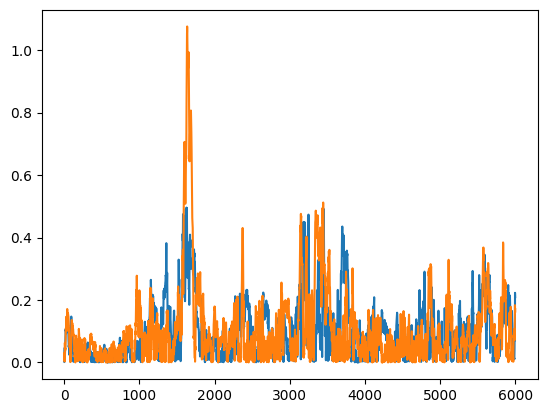

In [31]:
from x_xy import maths
import jax.numpy as jnp
import matplotlib.pyplot as plt
errs2 = maths.angle_error(y["seg2"], yhat["seg2"])
errs3 = maths.angle_error(y["seg3"], yhat["seg3"])
avg2 = jnp.average(errs2)
avg3 = jnp.average(errs3)

print(avg2, avg3)

plt.plot(errs2)
plt.plot(errs3)
plt.show()

# Parameters 2 Video Pipeline:tm:

best_run
{'mae_deg_seg2': Array(5.633198, dtype=float32), 'mae_deg_seg3': Array(6.127283, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:23<00:00, 64.44it/s]


DONE. Converting frames to /data/uk16ural/prism_output/best_run_prediction.mp4 (this might take a while..)
{'mae_deg_seg2': Array(5.633198, dtype=float32), 'mae_deg_seg3': Array(6.127283, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:23<00:00, 64.88it/s]


DONE. Converting frames to /data/uk16ural/prism_output/best_run_real.mp4 (this might take a while..)
long_rigid_phase
{'mae_deg_seg2': Array(20.544207, dtype=float32), 'mae_deg_seg3': Array(28.661587, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:23<00:00, 64.29it/s]


DONE. Converting frames to /data/uk16ural/prism_output/long_rigid_phase_prediction.mp4 (this might take a while..)
{'mae_deg_seg2': Array(20.544207, dtype=float32), 'mae_deg_seg3': Array(28.661587, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:23<00:00, 64.29it/s]


DONE. Converting frames to /data/uk16ural/prism_output/long_rigid_phase_real.mp4 (this might take a while..)
many_tiny_stops
{'mae_deg_seg2': Array(19.023829, dtype=float32), 'mae_deg_seg3': Array(26.067352, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:23<00:00, 64.21it/s]


DONE. Converting frames to /data/uk16ural/prism_output/many_tiny_stops_prediction.mp4 (this might take a while..)
{'mae_deg_seg2': Array(19.023829, dtype=float32), 'mae_deg_seg3': Array(26.067352, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:23<00:00, 64.56it/s]


DONE. Converting frames to /data/uk16ural/prism_output/many_tiny_stops_real.mp4 (this might take a while..)
some_short_stops_1
{'mae_deg_seg2': Array(72.48051, dtype=float32), 'mae_deg_seg3': Array(47.267124, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:23<00:00, 63.50it/s]


DONE. Converting frames to /data/uk16ural/prism_output/some_short_stops_1_prediction.mp4 (this might take a while..)
{'mae_deg_seg2': Array(72.48051, dtype=float32), 'mae_deg_seg3': Array(47.267124, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:23<00:00, 64.07it/s]


DONE. Converting frames to /data/uk16ural/prism_output/some_short_stops_1_real.mp4 (this might take a while..)
some_rigid_phases
{'mae_deg_seg2': Array(103.63409, dtype=float32), 'mae_deg_seg3': Array(50.403805, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:26<00:00, 56.74it/s]


DONE. Converting frames to /data/uk16ural/prism_output/some_rigid_phases_prediction.mp4 (this might take a while..)
{'mae_deg_seg2': Array(103.63409, dtype=float32), 'mae_deg_seg3': Array(50.403805, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:23<00:00, 63.59it/s]


DONE. Converting frames to /data/uk16ural/prism_output/some_rigid_phases_real.mp4 (this might take a while..)
best_run_2
{'mae_deg_seg2': Array(6.1217155, dtype=float32), 'mae_deg_seg3': Array(7.978518, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:26<00:00, 56.57it/s]


DONE. Converting frames to /data/uk16ural/prism_output/best_run_2_prediction.mp4 (this might take a while..)
{'mae_deg_seg2': Array(6.1217155, dtype=float32), 'mae_deg_seg3': Array(7.978518, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:25<00:00, 57.71it/s]


DONE. Converting frames to /data/uk16ural/prism_output/best_run_2_real.mp4 (this might take a while..)
long_rigid_phase_2
{'mae_deg_seg2': Array(32.167564, dtype=float32), 'mae_deg_seg3': Array(44.54729, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:26<00:00, 56.46it/s]


DONE. Converting frames to /data/uk16ural/prism_output/long_rigid_phase_2_prediction.mp4 (this might take a while..)
{'mae_deg_seg2': Array(32.167564, dtype=float32), 'mae_deg_seg3': Array(44.54729, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:26<00:00, 57.02it/s]


DONE. Converting frames to /data/uk16ural/prism_output/long_rigid_phase_2_real.mp4 (this might take a while..)


ValueError: Not a file: /data/uk16ural/prism_params/some_short_stops.pickle

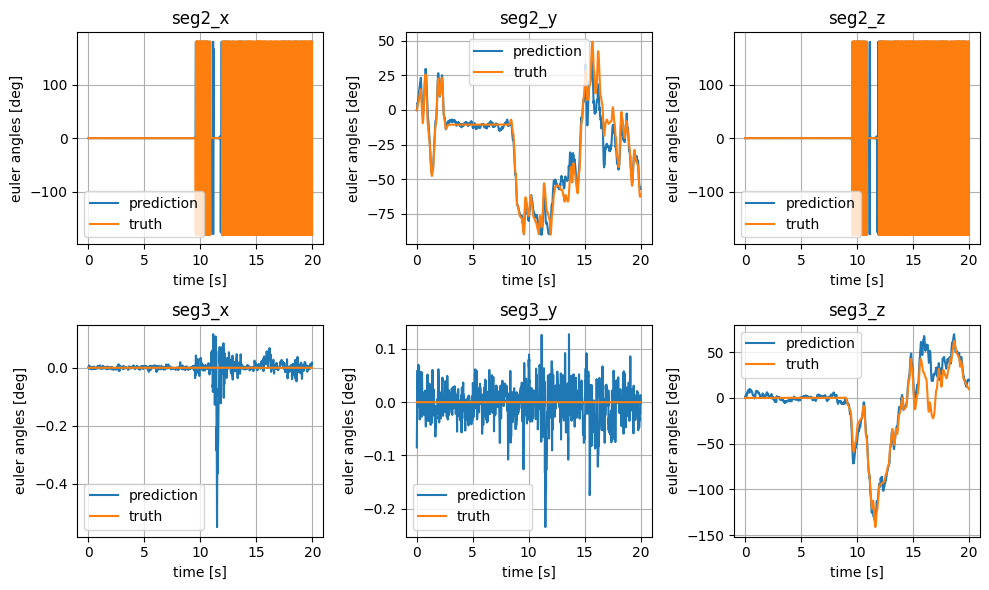

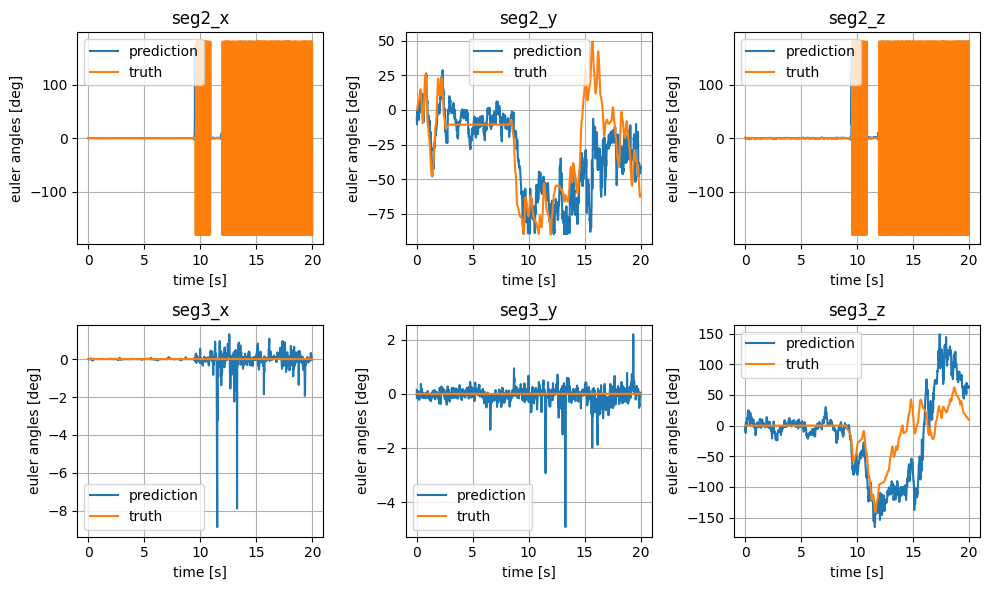

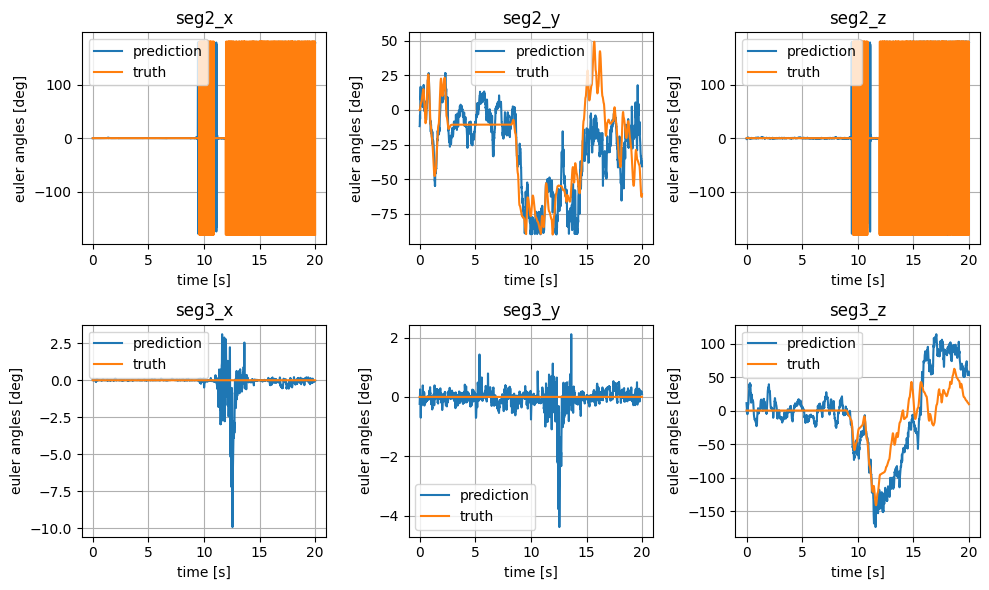

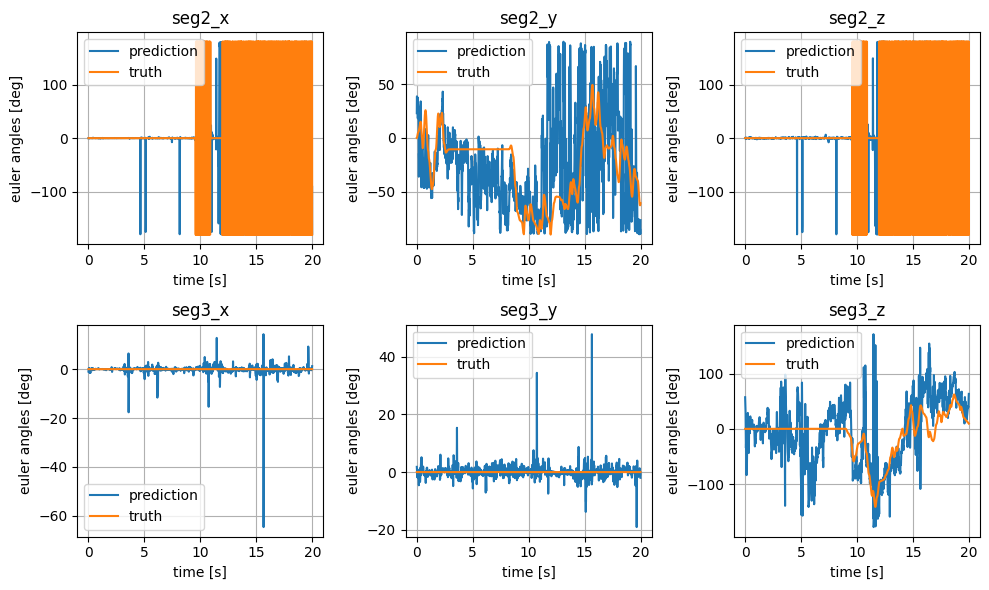

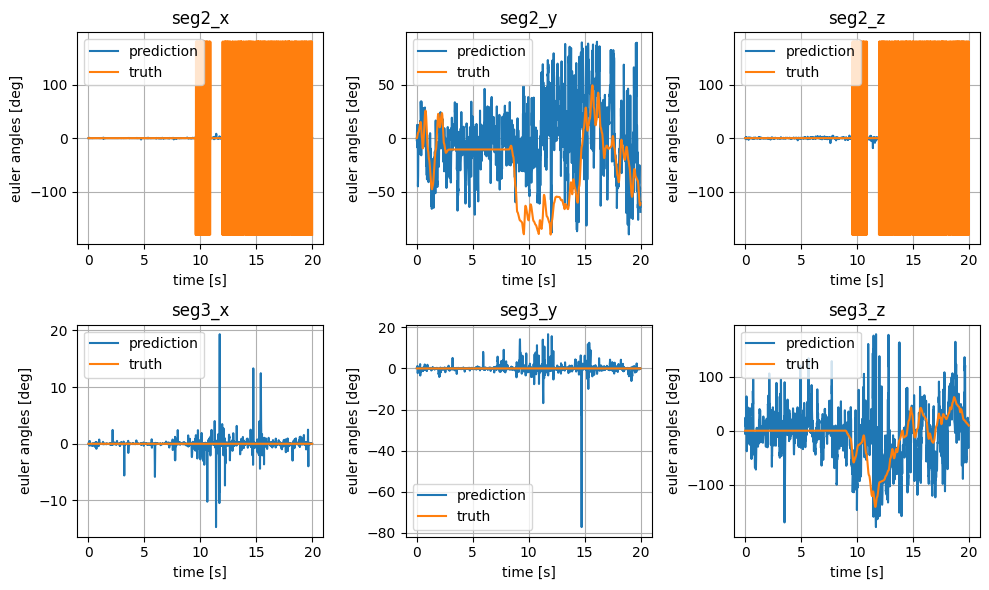

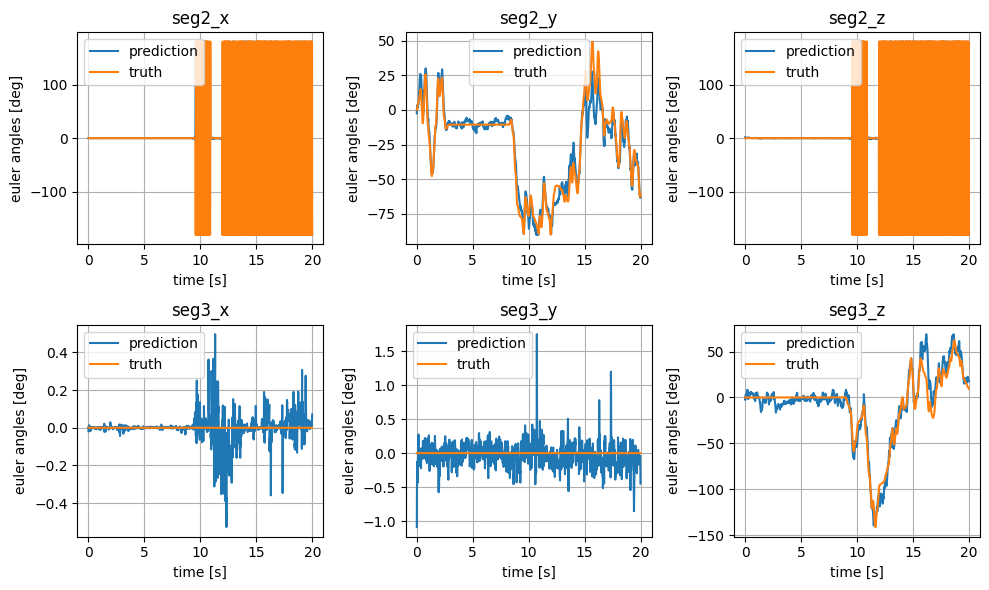

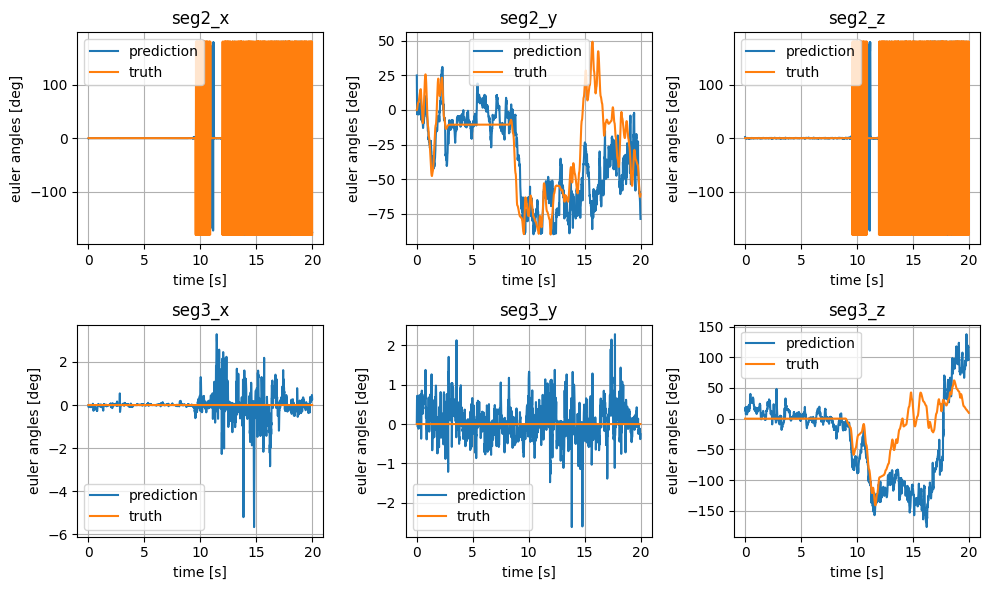

In [40]:
from x_xy.subpkgs import pipeline
from neural_networks.rnno import rnno_v2
import os

import IPython.core.debugger as pdb



user = os.environ["USER"]
run = False
# pdb.set_trace()
if run:
    for problem_name in problems.keys():
        params = load_pickle_params(problem_name)
        path = f"/data/{user}/prism_output/{problem_name}"
        for prediction in True, False:
            if prediction:
                print(problem_name)
                render_path = path + "_prediction"
            else:
                render_path = path + "_real"
                
            pipeline.predict(
                sys=dustin_sys,
                rnno_fn=rnno_v2,
                X=X,
                y=y,
                xs=xs,
                sys_xs=sys,
                params=params,
                plot=prediction,
                render=True,
                render_prediction=prediction,
                render_path=render_path
            )

some_short_stops
{'mae_deg_seg2': Array(105.77886, dtype=float32), 'mae_deg_seg3': Array(61.732998, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:10<00:00, 140.79it/s]


DONE. Converting frames to /data/uk16ural/prism_output/some_short_stops_prediction.mp4 (this might take a while..)
{'mae_deg_seg2': Array(105.77886, dtype=float32), 'mae_deg_seg3': Array(61.732998, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:09<00:00, 159.16it/s]


DONE. Converting frames to /data/uk16ural/prism_output/some_short_stops_real.mp4 (this might take a while..)
some_rigid_phases_2
{'mae_deg_seg2': Array(11.06208, dtype=float32), 'mae_deg_seg3': Array(11.819904, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:10<00:00, 139.31it/s]


DONE. Converting frames to /data/uk16ural/prism_output/some_rigid_phases_2_prediction.mp4 (this might take a while..)
{'mae_deg_seg2': Array(11.06208, dtype=float32), 'mae_deg_seg3': Array(11.819904, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:09<00:00, 160.83it/s]


DONE. Converting frames to /data/uk16ural/prism_output/some_rigid_phases_2_real.mp4 (this might take a while..)


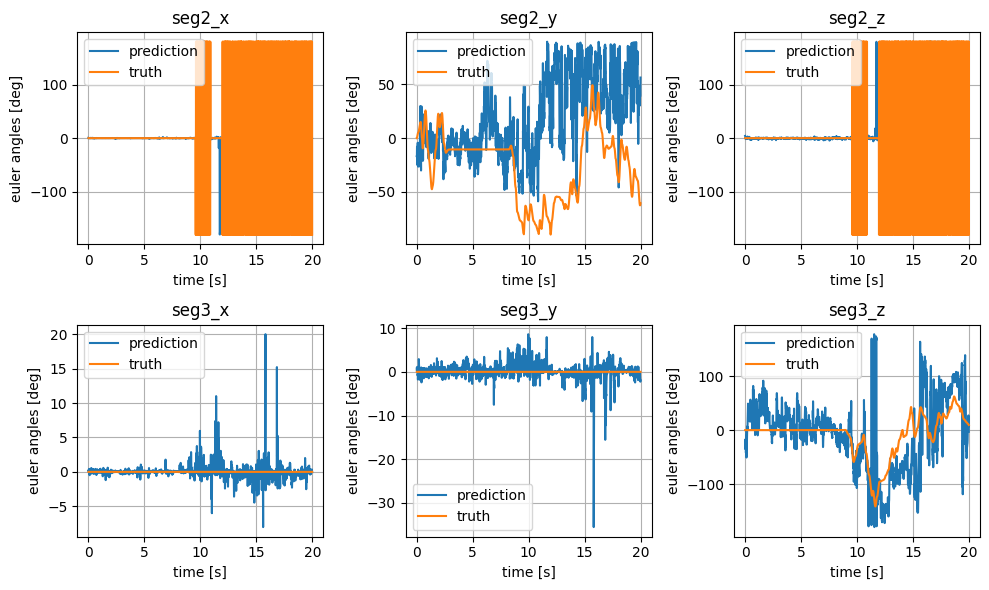

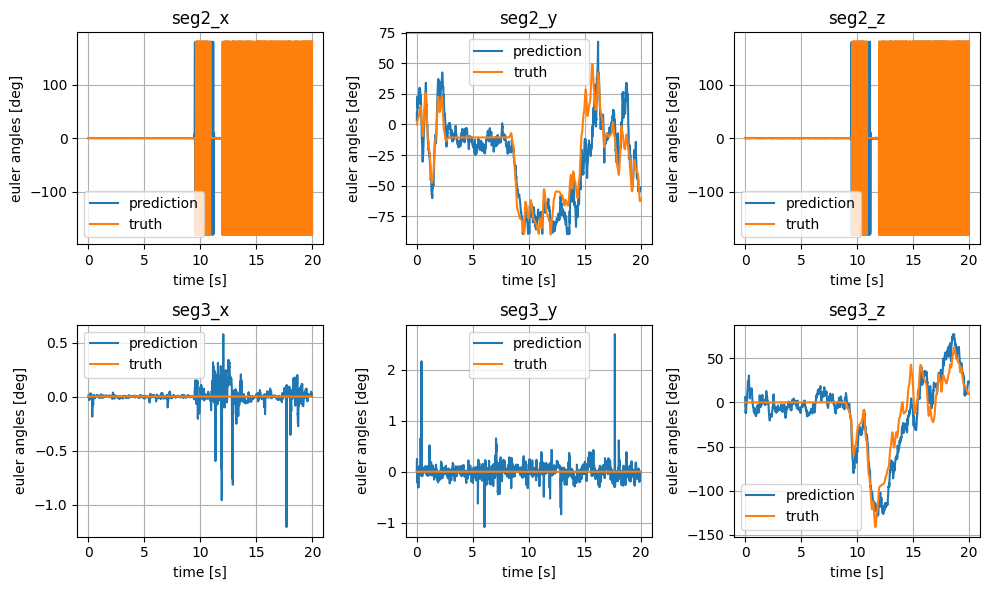

In [11]:
from x_xy.subpkgs import pipeline
from neural_networks.rnno import rnno_v2
import os
user = os.environ["USER"]

for problem_name in "some_short_stops", "some_rigid_phases_2":
    params = load_pickle_params(problem_name)
    path = f"/data/{user}/prism_output/{problem_name}"
    for prediction in True, False:
        if prediction:
            print(problem_name)
            render_path = path + "_prediction"
        else:
            render_path = path + "_real"
            
        pipeline.predict(
            sys=dustin_sys,
            rnno_fn=rnno_v2,
            X=X,
            y=y,
            xs=xs,
            sys_xs=sys,
            params=params,
            plot=prediction,
            render=True,
            render_prediction=prediction,
            render_path=render_path
        )

In [33]:
params = load_pickle_params("long_rigid_phase")


pipeline.predict(
    sys=dustin_sys,
    rnno_fn=rnno_v2,
    X=X,
    y=y,
    xs=xs,
    sys_xs=sys,
    params=params,
    plot=prediction,
    render=True,
    render_prediction=False,
    render_path="test2.mp4"
)
    
sys.geoms

{'mae_deg_seg2': Array(20.544207, dtype=float32), 'mae_deg_seg3': Array(28.661587, dtype=float32)}


Rendering frames..: 100%|██████████| 1500/1500 [00:12<00:00, 118.58it/s]


DONE. Converting frames to test2.mp4 (this might take a while..)


[Box(mass=Array(10., dtype=float32), transform=Transform(pos=Array([0.1, 0. , 0. ], dtype=float32), rot=Array([1., 0., 0., 0.], dtype=float32)), link_idx=0, dim_x=Array(0.2, dtype=float32), dim_y=Array(0.05, dtype=float32), dim_z=Array(0.05, dtype=float32), vispy_kwargs={'color': 'red', 'edge_color': 'black'}),
 Box(mass=Array(10., dtype=float32), transform=Transform(pos=Array([-0.1,  0. ,  0. ], dtype=float32), rot=Array([1., 0., 0., 0.], dtype=float32)), link_idx=1, dim_x=Array(-0.2, dtype=float32), dim_y=Array(0.05, dtype=float32), dim_z=Array(0.05, dtype=float32), vispy_kwargs={'color': 'yellow', 'edge_color': 'black'}),
 Box(mass=Array(2., dtype=float32), transform=Transform(pos=Array([0., 0., 0.], dtype=float32), rot=Array([1., 0., 0., 0.], dtype=float32)), link_idx=2, dim_x=Array(0.05, dtype=float32), dim_y=Array(0.01, dtype=float32), dim_z=Array(0.01, dtype=float32), vispy_kwargs={'color': 'green', 'edge_color': 'black'}),
 Box(mass=Array(10., dtype=float32), transform=Transfor

In [ ]:
params = load_pickle_params("long_rigid_phase")

pipeline.predict(
    sys=dustin_sys,
    rnno_fn=rnno_v2,
    X=X,
    y=y,
    xs=xs,
    sys_xs=sys,
    params=params,
    plot=prediction,
    render=True,
    render_prediction=False,
    render_path="test3.mp4"
)

# todo:
Evaluationsmatrix für
- alle Szenarien
- in verbindung mit allen anderen Szenarien
- inklusive Baseline
- bar graph: mean absolute winkelfehler
- im schnitt gemittelt über alle szenarien

Video hübsch machen